## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

## And so on and so forth...

In [1]:
from lanetracker.camera_calibrate import CameraCalibration
import glob
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from lanetracker.color_thresh import hls_select
from lanetracker.color_thresh import rgb_select
from lanetracker.gradient_thresh import abs_sobel_thresh
from lanetracker.gradient_thresh import magnitude_thresh
from lanetracker.gradient_thresh import direction_threshold
from lanetracker.lane_finder import first_frame_lane_finder
from lanetracker.lane_finder import frame_lane_finder
from lanetracker.perspective import flatten_perspective

%matplotlib inline

In [2]:
images = glob.glob('../data/camera_cal/calibration*.jpg')
cal = CameraCalibration(images, retain_calibration_patterns=True)

In [ ]:
# Show the success patterns detected by cv2.findChessboardCorners

print("Number of Success detected patterns: ", len(cal.calibration_patterns_success))

for success_img in cal.calibration_patterns_success:
    plt.imshow(success_img)
    plt.show()

In [ ]:
# Show the fail patterns which are not detected by cv2.findChessboardCorners
# And correct it with calibration method
print("Number of Fail detected patterns: ", len(cal.calibration_patterns_error))

for fail_img in cal.calibration_patterns_error:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    axes[0].set_title("Before calibration: ")
    axes[0].set_axis_off()
    axes[1].set_title("After calibration: ")
    axes[1].set_axis_off()
    axes[0].imshow(fail_img)
    axes[1].imshow(cal(fail_img))


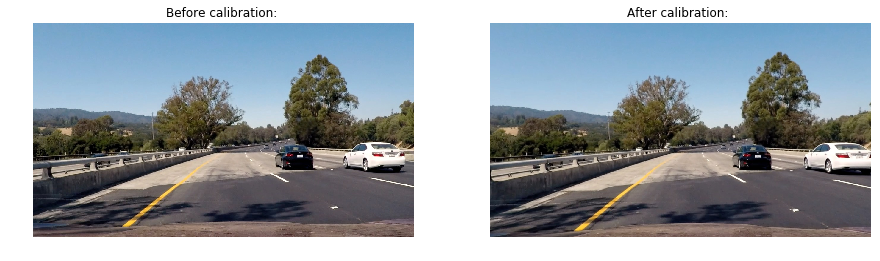

In [3]:
# Test CameraCalibration on car image

img = mpimg.imread('../test_images/test4.jpg')
# img = mpimg.imread('../test_images/straight_lines1.jpg')
# img = mpimg.imread('frame.jpeg')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].set_title("Before calibration: ")
axes[0].set_axis_off()
axes[0].imshow(img)

img_after_calibration = cal(img)

axes[1].set_title("After calibration: ")
axes[1].set_axis_off()
axes[1].imshow(img_after_calibration)

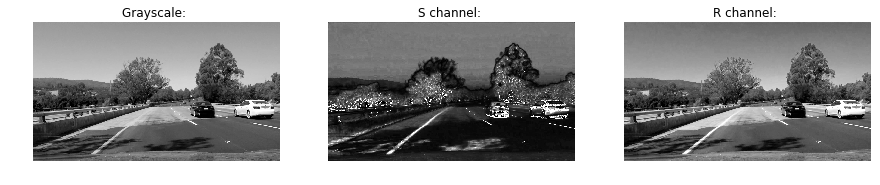

In [4]:
# grayscale vs s channel vs r channel: 
# We found that S channel could make white and yellow lane more contrastive to their background.
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
s_channel_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:, :, 2]
r_channel_img = img[:, :, 0]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes[0].set_title("Grayscale: ")
axes[0].set_axis_off()
axes[0].imshow(gray, cmap='gray')

axes[1].set_title("S channel: ")
axes[1].set_axis_off()
axes[1].imshow(s_channel_img, cmap='gray')

axes[2].set_title("R channel: ")
axes[2].set_axis_off()
axes[2].imshow(r_channel_img, cmap='gray')

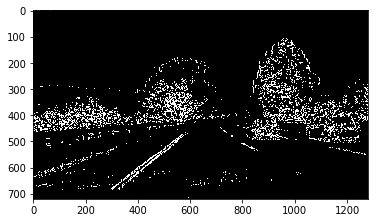

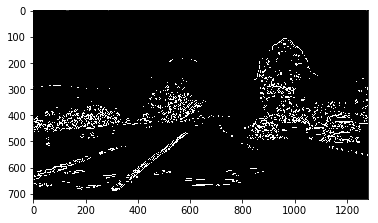

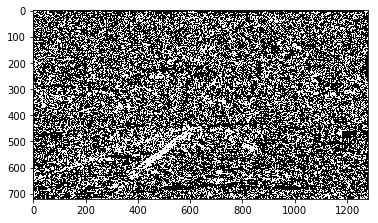

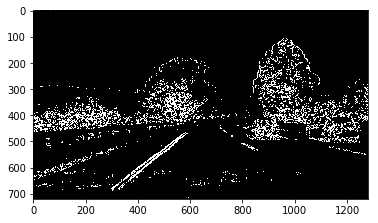

In [5]:
# Apply each of gredient thresholding functions

gradx_binary = abs_sobel_thresh(s_channel_img, orient='x', sobel_kernel=3, thresh=(20, 100), debug=True)
# mag_binary = magnitude_thresh(gray, sobel_kernel=9, thresh=(50, 100), debug=True)
mag_binary = magnitude_thresh(s_channel_img, sobel_kernel=9, thresh=(50, 100), debug=True)
# dir_binary = direction_threshold(gray, sobel_kernel=15, thresh=(0.7, 1.3), debug=True)
dir_binary = direction_threshold(s_channel_img, sobel_kernel=15, thresh=(0.7, 1.3), debug=True)

combined_binary = np.zeros_like(dir_binary)
combined_binary[(gradx_binary == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
plt.imshow(combined_binary, cmap='gray');

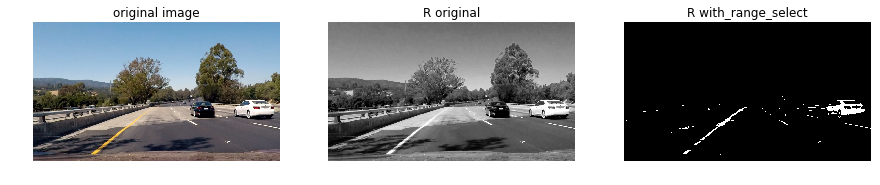

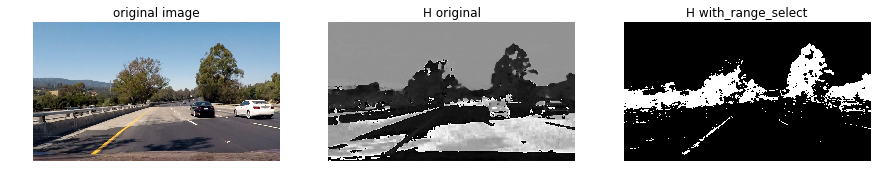

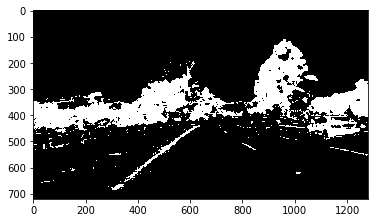

In [6]:
r_binary = rgb_select(img, channel='R', thresh=(220, 255), debug=True)
# s_binary = hls_select(img, thresh=(70, 235), debug=False)
# s_binary = hls_select(img, thresh=(70, 235), debug=True)
# h_binary = hls_select(img, channel='h', thresh=(17, 70), debug=False)
h_binary = hls_select(img, channel='h', thresh=(19, 70), debug=True)

combined_binary = np.zeros_like(r_binary)
combined_binary[(h_binary == 1) | (r_binary == 1)] = 1
plt.imshow(combined_binary, cmap='gray');

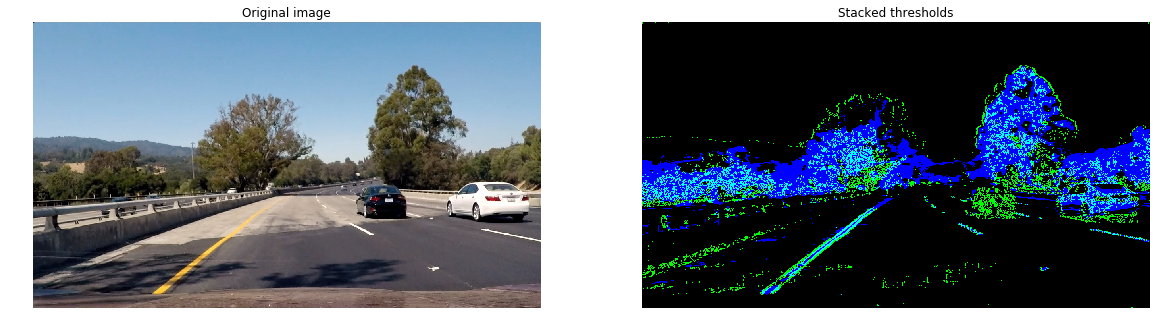

In [7]:
gradx_binary = abs_sobel_thresh(s_channel_img, orient='x', sobel_kernel=3, thresh=(20, 100), debug=False)
mag_binary = magnitude_thresh(s_channel_img, sobel_kernel=9, thresh=(50, 100), debug=False)
dir_binary = direction_threshold(s_channel_img, sobel_kernel=15, thresh=(0.7, 1.3), debug=False)
r_binary = rgb_select(img, channel='R', thresh=(220, 255), debug=False)
# s_binary = hls_select(img, thresh=(70, 235), debug=True)
h_binary = hls_select(img, channel='h', thresh=(19, 70), debug=False)

combined_binary = np.zeros_like(gradx_binary)
gredient_binary = np.zeros_like(gradx_binary)
color_binary = np.zeros_like(gradx_binary)
gredient_binary[(gradx_binary == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
color_binary[(h_binary == 1) | (r_binary == 1)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors.
#
# Green: gredient_binary
# Blue: color_binary
green_blue_binary = np.dstack((np.zeros_like(gredient_binary), gredient_binary, color_binary)) * 255

combined_binary[(gradx_binary == 1) | ((mag_binary == 1) & (dir_binary == 1)) | ((h_binary == 1) | (r_binary == 1))] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

# ax1.set_title('Combined S channel and gradient thresholds')
# ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('Original image')
ax1.set_axis_off()
ax1.imshow(img)


ax2.set_title('Stacked thresholds')
ax2.set_axis_off()
ax2.imshow(green_blue_binary)

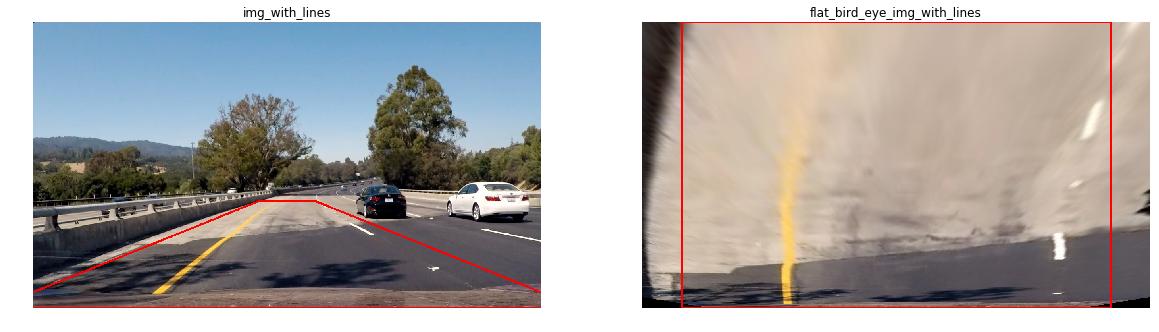

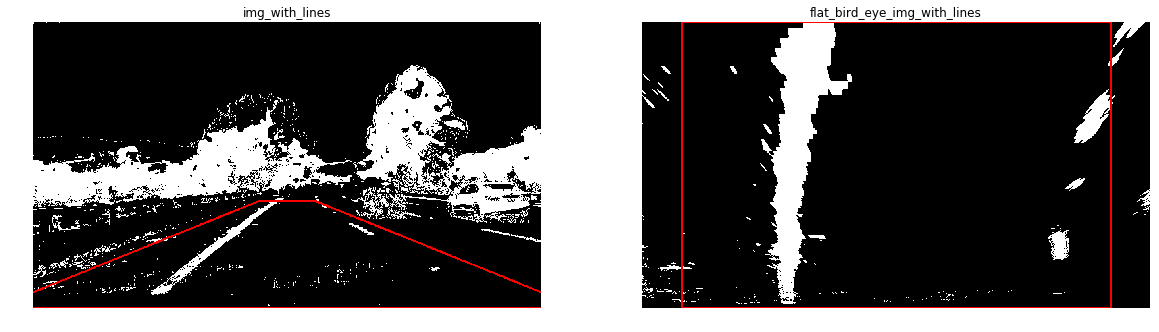

In [14]:
# bird_eye_binary, M = flatten_perspective(combined_binary, camera_offset=-30, half_of_lane_width=125, debug=True)
bird_eye_binary, M = flatten_perspective(img, top_offset=70, debug=True)
bird_eye_binary, M = flatten_perspective(combined_binary, top_offset=70, debug=True)

[[  710.   450.]
 [ 1380.   720.]
 [ -100.   720.]
 [  570.   450.]]
[[ 1180.     0.]
 [ 1180.   720.]
 [  100.   720.]
 [  100.     0.]]


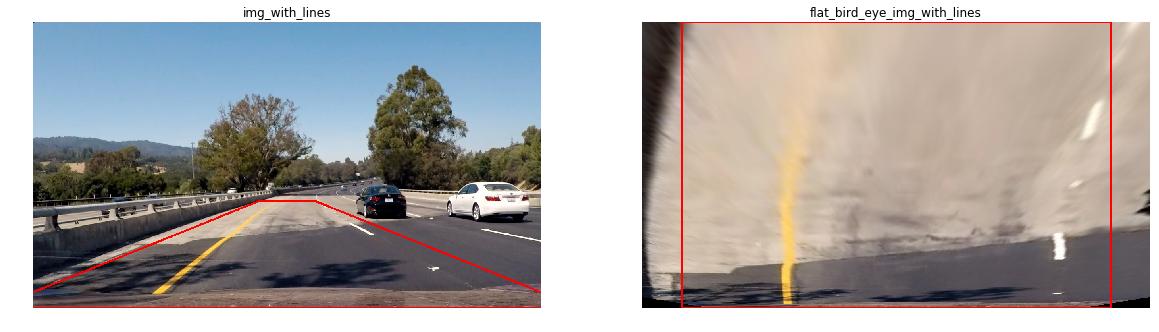

In [15]:
def flatten_perspective(img, camera_offset=0, top_offset=70, debug=False):
    """
    Mapping the image from the vehicle front-facing camera to a bird view.
    
    Parameters
    ----------
    img                : Image from the vehicle front-facing camera.
    camera_offset      : The midden x position of the car view - The midden x position of the image
    top_offset         : the offset to control the x value of src vertices with y value equal to roi_y_top.

    Returns
    -------
    Warped image.

    """

    # Get image dimensions
    (h, w) = (img.shape[0], img.shape[1])
    
    roi_y_top = h*0.625
    mid_x = w//2         # midden position of x coordinate in the given image

#     dst_w_offset = 300
    
    # The reason why I use these src and dst vertices is to handle each image with different camera position.
    src_vertices = np.array([[mid_x + top_offset + camera_offset, roi_y_top], [w + 100 + camera_offset, h], [-100 + camera_offset, h], [mid_x - top_offset + camera_offset, roi_y_top]], dtype=np.int32)
    # Define corresponding destination points
    dst_vertices = np.array([[w - 100 + camera_offset, 0], [w - 100 + camera_offset, h], [100 + camera_offset, h], [100 + camera_offset, 0]], dtype=np.int32)
    
#     src_vertices = np.array([[mid_x + offset, roi_y_top], [w - 160, h], 
#                              [200, h], [mid_x - offset, roi_y_top]], dtype=np.int32)
#     dst_vertices = np.array([[w - dst_w_offset, 0], [w - dst_w_offset, h], 
#                              [dst_w_offset, h]    , [dst_w_offset, 0]], dtype=np.int32)
        
    src = np.float32(src_vertices)
    print(src)
    dst = np.float32(dst_vertices)
    print(dst)
    
    # perspective transform is a matrix that's returned by the function
    # getPerspectiveTranform
    M = cv2.getPerspectiveTransform(src, dst)
    
    img_size = (img.shape[1], img.shape[0])
    
    # Apply the transform M to the original image to get the wraped image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    if debug == True:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

        # original img with line
        if img.ndim == 2:
            channel = np.uint8(255*img)
            img_with_lines = np.dstack((channel, channel, channel))
        else:
            img_with_lines = img.copy()
            
        pts = src_vertices.reshape((-1,1,2))
        lines = cv2.polylines(img_with_lines, [pts], True, (255,0,0), thickness=3)
        ax1.set_title('img_with_lines')
        ax1.set_axis_off()
        ax1.imshow(img_with_lines)
        
        # flat bird-eye img with line
        if img.ndim == 2:
            channel = np.uint8(255*warped)
            flat_bird_eye_img_with_lines = np.dstack((channel, channel, channel))
        else:
            flat_bird_eye_img_with_lines = warped.copy()
        pts = dst_vertices.reshape((-1,1,2))
        lines = cv2.polylines(flat_bird_eye_img_with_lines, [pts], True, (255,0,0), thickness=3)
        ax2.set_title('flat_bird_eye_img_with_lines')
        ax2.set_axis_off()
        ax2.imshow(flat_bird_eye_img_with_lines)
        plt.show()

    return warped, M

flatten_perspective(img, top_offset=70, debug=True);

In [ ]:
out_img, _, _ = first_frame_lane_finder(bird_eye_binary, M, img)
plt.imshow(out_img)
plt.show()

In [ ]:
def static_var(varname, value):
    def decorate(func):
        setattr(func, varname, value)
        return func
    return decorate

@static_var("counter", 0)
@static_var("left_fit", None)
@static_var("right_fit", None)
def pipeline(img):
    pipeline.counter += 1
    img = cal(img)
    s_channel_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:, :, 2]
    
    r_binary = rgb_select(img, channel='R', thresh=(215, 255), debug=False)
    s_binary = hls_select(img, thresh=(70, 235), debug=False)
    gradx_binary = abs_sobel_thresh(s_channel_img, orient='x', sobel_kernel=3, thresh=(20, 150), debug=False)
    h_binary = hls_select(img, channel='h', thresh=(19, 70), debug=False)
    
    combined_binary = np.zeros_like(gradx_binary)
    combined_binary[(gradx_binary == 1) | (((h_binary == 1) & (s_binary == 1)) | (r_binary == 1))] = 1
    out_img = np.dstack((combined_binary, combined_binary, combined_binary)) * 255
    
    
    bird_eye_binary, M = perspective_transform(combined_binary, camera_offset=-30, helf_of_lane_width=125 , debug=False)

#     bird_eye_binary, M = flatten_perspective(combined_binary, half_of_lane_width=70, debug=False)
    if pipeline.counter == 1:
        out_img, pipeline.left_fit, pipeline.right_fit = first_frame_lane_finder(bird_eye_binary, M, img, debug=False)
    else:
        out_img, pipeline.left_fit, pipeline.right_fit = frame_lane_finder(bird_eye_binary, 
                                                pipeline.left_fit, pipeline.right_fit, M, img, debug=False)
    return out_img.astype(np.uint8)

In [ ]:
out_img = pipeline(img);
plt.imshow(out_img)

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
challenge_output = '../test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip1 = VideoFileClip('../test_videos/challenge.mp4').subclip(0,3)
challenge_clip = clip1.fl_image(pipeline)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
challenge_output = '../test_videos_output/4K.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
# clip1 = VideoFileClip('../test_videos/4K.mp4').subclip(405,410)
clip1 = VideoFileClip('../test_videos/4K.mp4').subclip(80,85)
# clip1 = VideoFileClip('../test_videos/4K.mp4').subclip(25,27)
# clip1.save_frame("frame.jpeg", t=25)
challenge_clip = clip1.fl_image(pipeline)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
# # Apply each of the thresholding functions
# gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(10, 100))
# grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(10, 100))
# mag_binary = magnitude_thresh(img, sobel_kernel=9, thresh=(30, 100))
# dir_binary = direction_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))

# combined = np.zeros_like(dir_binary)
# combined[((gradx == 1) | (mag_binary == 1) & (dir_binary == 1))] = 1
# plt.imshow(combined, cmap='gray');

In [ ]:
# bird_eye_binary, M = flatten_perspective(combined_binary, debug=True)

In [ ]:
# r_binary = rgb_select(img, channel='R', thresh=(180, 255))
# # s_binary = hls_select(img, thresh=(90, 255), debug=True)
# gradx_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(10, 150))

# combined_binary = np.zeros_like(gradx_binary)
# combined_binary[(gradx_binary == 1) | (r_binary == 1)] = 1
# plt.imshow(combined_binary, cmap='gray')

In [ ]:
# bird_eye_binary, M = perspective_transform(combined_binary, debug=False)

In [ ]:
# out_img = bird_eye_view(bird_eye_binary, M, img, debug=True)

In [ ]:
# class line():
#     def __init__(self):
#         # was the line detected in the last iteration?
#         self.detected = False
#         # x values of the last n fits 

In [ ]:
# Warp the detected lane boundaries back onto the original image.
# Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.